Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [1]:
from random import choices, random, randint, shuffle
import numpy as np
from copy import deepcopy
from IPython.display import clear_output
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 120
plt.rcParams.update({'font.size': 15})

import lab9_lib

# GOAL: maximize fitness, minimize calls

In [2]:
fitness = lab9_lib.make_problem(5)
for n in range(20):
    ind = choices([0, 1], k=100)
    print(f"{''.join(str(g) for g in ind)}: {fitness(ind):.2%}")

print(fitness.calls)

1001111101110111010110111001001101011010111100001111101110110001000100101111111001111111001010011000: 13.67%
1011000001000011010001111010011001101011101110000110001111001000110111000000001110001011011011101100: 13.90%
0000010101111111110101011110101110000110100110100010001011000100110100101111101111110001101101001111: 22.78%
1000100000110010100111110111011011101110001101011101001111000001010010111101100011101010110101001100: 11.79%
1111010110001000110000111101011010100100001101001000110101100010010010011011101000111100001011011101: 14.78%
0100101001000001011100010111000000110001101011001011011011101111000011110100111011010100010010000011: 9.89%
1101110110111011000001111011010100001110001010000010011001001110101011111101110010101000001010110110: 11.79%
1001111011101101001101100010111110110000000111100101010011111101100011001000001111011111011010011011: 12.57%
1010100001011000001100010000011000111010110001111010000011111010001010101111111111101100111000011000: 11.90%
01111000010100111010

In [3]:
import math 

def plot(history_dict: dict, model='') -> None:
    colors = {1:'red', 2:'blue', 5:'green', 10:'orange'}
    offset = 0.75
    len_x = max([len(item[1]) for item in history_dict.values()])
    plt.title(f'{model}')
    plt.xticks(range(0, math.ceil(len_x/10)*10, 5))
    plt.xlabel('#generation')
    plt.ylabel('fitness')
    for k, v in history_dict.items():
        plt.plot(v[1], label=f'k = {k}', color=colors[k])
        plt.axvline(x=v[0][-1]-offset, color=colors[k], linestyle='dashed')
    plt.legend()
    plt.show()

Our code below

In [4]:
POPULATION_SIZE = 500
OFFSPRING_SIZE = 200
LOCI = 1000
BIT_FLIP_PROBABILITY = 0.15
# SWAP_PROBABILITY = 150 * 1/LOCI
SWAP_PROBABILITY = 0.5
NUM_GENERATION = 20


class Individual:
    def __init__(self):
        self.genotype = choices([0, 1], k=LOCI)
        self.fitness = float("-inf")

In [5]:
# Mutation / recombination or both
def parent_selection(
    population: list[Individual], tournament_size: int
) -> Individual:
    # we also want to take the last best one.
    parents_idx = np.random.choice(
        range(len(population)), size=tournament_size, replace=False
    )
    parents = [population[idx] for idx in parents_idx]
    return max(parents, key=lambda i: i.fitness)


def uniform_cut_xover(ind1: Individual, ind2: Individual) -> Individual:
    p1 = ind1.fitness / (ind1.fitness + ind2.fitness)
    mask = np.random.choice([True, False], size=LOCI, p=[p1, 1 - p1])
    gene = np.where(mask, ind1.genotype, ind2.genotype)
    new_ind = Individual()
    new_ind.genotype = gene.tolist()
    return new_ind

'''NOT USEFUL'''
# def uniform_cut_xover_old(ind1: Individual, ind2: Individual) -> list[Individual]:
#     ind1.genotype = np.array(ind1.genotype)
#     ind2.genotype = np.array(ind2.genotype)
#     swap_mask = np.random.rand(len(ind1.genotype)) < SWAP_PROBABILITY
#     temp = np.copy(ind1.genotype[swap_mask])
#     ind1.genotype[swap_mask] = ind2.genotype[swap_mask]
#     ind2.genotype[swap_mask] = temp
#     return [ind1, ind2]


def mutate(parent: Individual) -> Individual:
    new_offspring = deepcopy(parent)
    for i in range(LOCI):
        if random() < BIT_FLIP_PROBABILITY:
            new_offspring.genotype[i] = int(not new_offspring.genotype[i])
    return new_offspring


def offspring_generation(
    parent1: Individual, parent2: Individual, mutation_probability: int
) -> Individual:
    offspring = uniform_cut_xover(parent1, parent2)
    offspring = mutate(offspring) if random() < random() < mutation_probability else offspring
    offspring.fitness = fitness(offspring.genotype)
    return offspring
            

def ea() -> Individual:
    fitness_list = []
    gen_list = []
    # starting pouplation of POPULATION_SIZE individuals
    population = [Individual() for _ in range(POPULATION_SIZE)]
    for p in population:
        p.fitness = fitness(p.genotype)
    best_fitness = population[0].fitness
    gen = 0
    fitness_stall = 0 
    mutation_probability = 0.15
    tournament_size = 3
    while fitness_stall < 20 or gen < NUM_GENERATION:
        offsprings = []
        for _ in range(OFFSPRING_SIZE):
            parent1 = parent_selection(population, tournament_size)
            parent2 = parent_selection(population, tournament_size)
            offspring = offspring_generation(
                parent1, parent2, mutation_probability
            )
            offsprings.append(offspring)
            #population.extend([offspring]) if isinstance(offspring, Individual) else population.extend(offspring)            # tracking the number of offspring better than the best old one.
        population.extend(offsprings)

        population.sort(key=lambda i: i.fitness, reverse=True)
        # always keep the first POPULATION_SIZE best individuals
        population = population[:POPULATION_SIZE]

        #  Self-adapting the values.
        # TODO favour mutation insted of recombination if the fitness it's not high (<0.65).
        if fitness_stall > 5:
            # If we are able to generate 5% of offsprings better than the father,
            # We should explore more.
            mutation_probability *= 1.3

        if best_fitness == population[0].fitness:
            fitness_stall += 1
        else:
            best_fitness = population[0].fitness
            fitness_stall = 0
            mutation_probability = 0.15

        # fitness_list.append(best_fitness)
        gen += 1
        fitness_list.append(best_fitness)
        gen_list.append(gen)
        clear_output(wait=True)
        print(
            f"gen #{gen}, fitness: {best_fitness}, score: {best_fitness/gen * 1000:.4f}"
        )

    return population[0], gen_list, fitness_list

In [6]:
# instance = [1, 2, 5, 10]
history_dict = {}
instance = [1, 2, 5, 10]
for k in instance:
    fitness = lab9_lib.make_problem(k)
    best_individual, gen_list, fitness_list = ea()
    history_dict[k] = (gen_list, fitness_list)
    best_fitness = best_individual.fitness
    print(f"\nBest individual fitness: {best_fitness}, Fitness calls: {fitness.calls} -> Score2: {best_fitness/fitness.calls*10000000:.4f}")

gen #43, fitness: 0.27886897, score: 6.4853

Best individual fitness: 0.27886897, Fitness calls: 9100 -> Score2: 306.4494


### Plot

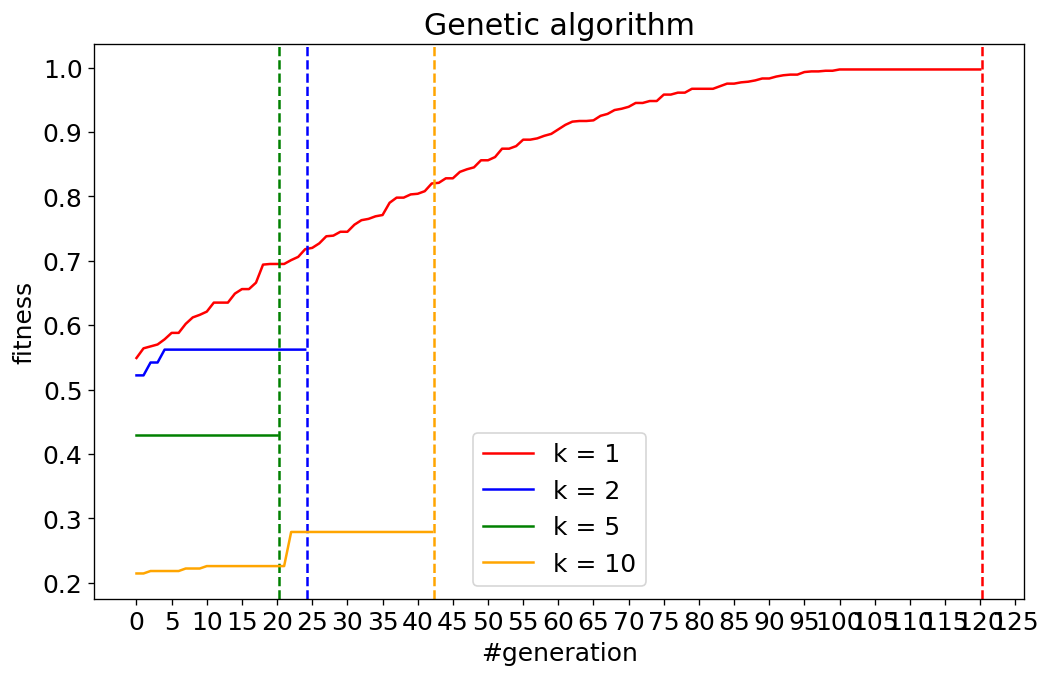

In [7]:
plot(history_dict, model=f'Genetic algorithm')

## Island model

In [8]:
class Island:
   def __init__(self, population_size, offspring_size, tournament_size, mutation_rate):
      self.population_size = population_size
      population = [Individual() for _ in range(population_size)]
      for p in population:
        p.fitness = fitness(p.genotype)
      self.population = population
      self.offspring_size = offspring_size
      self.mutation_rate = mutation_rate
      self.tournament_size = tournament_size
   
   def evolve(self, num_generations: int) -> Individual:
      for _ in range(num_generations):
         offsprings = []
         for _ in range(self.offspring_size):
            parent1 = parent_selection(self.population,self.tournament_size)
            parent2 = parent_selection(self.population,self.tournament_size)
            offspring = offspring_generation(
                  parent1, parent2, self.mutation_rate
            )
            offsprings.append(offspring)
         self.population.extend(offsprings)
         self.population.sort(key=lambda i: i.fitness, reverse=True)
         # always keep the first POPULATION_SIZE best individuals
         self.population = self.population[:POPULATION_SIZE]
      return self.population[0]
   
   def emigrate(self, num_of_migrations: int) -> list:
      migrants = np.random.choice(self.population, size = num_of_migrations, replace = False)
      self.population = [ind for ind in self.population if ind not in migrants]
      return migrants
   
   def immigrate(self, migrants):
      self.population.extend(migrants)

In [9]:
from itertools import combinations

POPULATION_SIZE = 100
OFFSPRING_SIZE = 100
RATIO = 10
NUM_ISLAND = 10
MIGRATION_FREQUENCY = 30
FITNESS_STALL_LIMIT = 60/MIGRATION_FREQUENCY
MIGRATION_NUMBER = POPULATION_SIZE//RATIO
TOURNAMENT_SIZE = 3 
MUTATION_RATE = 0.2

def island_model(): 
    islands = [Island(population_size=POPULATION_SIZE, offspring_size=OFFSPRING_SIZE, tournament_size = TOURNAMENT_SIZE, mutation_rate = MUTATION_RATE ) for _ in range(NUM_ISLAND)]
    fitness_stall = 0 
    best_fitness = float('-inf')
    gen = 0
    fitness_list = []
    gen_list = []
    while fitness_stall < FITNESS_STALL_LIMIT: 
        old_best = best_fitness
        for island in islands:
            best_individual = island.evolve(MIGRATION_FREQUENCY)
            best_fitness = best_individual.fitness if best_fitness < best_individual.fitness else best_fitness
        # migrations
        migrants = [island.emigrate(MIGRATION_NUMBER) for island in islands]
        shuffle(migrants)
        for i in range(NUM_ISLAND):
            islands[i].immigrate(migrants[i])
        
        gen += MIGRATION_FREQUENCY
        fitness_list.append(best_fitness)
        gen_list.append(gen)
        clear_output(wait=True)
        print(f"gen #{gen}, fitness: {best_fitness}, score: {best_fitness/gen * 1000:.4f}")
        
        fitness_stall = fitness_stall + 1 if best_fitness == old_best else 0
    
    return best_fitness, gen_list, fitness_list

In [10]:
instance = [2]
history_dict = {}
for k in instance:
    fitness = lab9_lib.make_problem(k)
    best_fitness, gen_list, fitness_list  = island_model()
    history_dict[k] = (gen_list, fitness_list)
    print(f"\nBest individual fitness: {best_fitness}, Fitness calls: {fitness.calls} -> Score2: {best_fitness/fitness.calls*10000000:.4f}")

gen #570, fitness: 0.93, score: 1.6316

Best individual fitness: 0.93, Fitness calls: 571000 -> Score2: 16.2872
